<a href="https://colab.research.google.com/github/SatoruGojo9/24f1002697_git_challenge_lab/blob/main/Copy_of_customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imported Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, precision_score, recall_score)
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
torch.manual_seed(42)

## Load the Dataset and Initial Insights Gathering

In [4]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
print(df.shape)
print(df.memory_usage(deep=True).sum())
print(df.head())

info_df = pd.DataFrame({
    'Column' : df.columns,
    'Data Type' : df.dtypes,
    'Non-Null Count' : df.count(),
    'Null Count' : df.isnull().sum(),
    'Null %' : (df.isnull().sum() / len(df) * 100).round(2),
    'Unique Values' : df.nunique()
})

print(info_df.to_string(index=False))

(7043, 21)
7152287
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies  

In [6]:
churn_counts = df['Churn'].value_counts()
churn_percentage = df['Churn'].value_counts(normalize=True) * 100

print(churn_percentage)

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [7]:
minority_class = churn_counts.min()
majority_class = churn_counts.max()
imbalance_ratio = majority_class / minority_class

print(f' Class imbalance ratio : {imbalance_ratio:.1f}:1')

 Class imbalance ratio : 2.8:1


In [8]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'customerID' in numeric_cols:
    numeric_cols.remove('customerID')

print(df[numeric_cols].describe())

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [10]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')

for col in categorical_cols[:]:
    unique_count = df[col].nunique()
    print(f"  {col}: {unique_count} unique values - {list(df[col].unique())}")

if len(categorical_cols) > 5:
   print(f"  ... and {len(categorical_cols) - 5} more categorical columns")

  gender: 2 unique values - ['Female', 'Male']
  Partner: 2 unique values - ['Yes', 'No']
  Dependents: 2 unique values - ['No', 'Yes']
  PhoneService: 2 unique values - ['No', 'Yes']
  MultipleLines: 3 unique values - ['No phone service', 'No', 'Yes']
  InternetService: 3 unique values - ['DSL', 'Fiber optic', 'No']
  OnlineSecurity: 3 unique values - ['No', 'Yes', 'No internet service']
  OnlineBackup: 3 unique values - ['Yes', 'No', 'No internet service']
  DeviceProtection: 3 unique values - ['No', 'Yes', 'No internet service']
  TechSupport: 3 unique values - ['No', 'Yes', 'No internet service']
  StreamingTV: 3 unique values - ['No', 'Yes', 'No internet service']
  StreamingMovies: 3 unique values - ['No', 'Yes', 'No internet service']
  Contract: 3 unique values - ['Month-to-month', 'One year', 'Two year']
  PaperlessBilling: 2 unique values - ['Yes', 'No']
  PaymentMethod: 4 unique values - ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automati

## Data Quality Assessment and Little Cleanup

In [11]:
df_cleaned = df.copy()
orignal_shape = df_cleaned.shape

print(orignal_shape)

(7043, 21)


In [12]:
duplicate_customers = df_cleaned['customerID'].duplicated().sum()
print(duplicate_customers) # we don't have any duplicate rows

0


In [13]:
print(df_cleaned['TotalCharges'].dtype)

object


In [14]:
non_numeric_total = df_cleaned['TotalCharges'].apply(lambda x: not str(x).replace('.', '').replace(' ', '').isdigit())

non_numeric_count = non_numeric_total.sum()
#print(non_numeric_count) -> we had 11 values here

df_cleaned['TotalCharges'] = pd.to_numeric(df_cleaned['TotalCharges'], errors='coerce')

print(df_cleaned['TotalCharges'].dtype) ## converted the total charges column  data type from object to float

float64


## Sample Example demonstration

In [15]:
import pandas as pd

# Sample data with different types of strings
sample_series = pd.Series(['123', '45.67', ' 789', 'abc', '10.00 '])

print("Original Sample Series:")
display(sample_series)

# Step 1 & 2: Convert to string and remove '.' and ' '
cleaned_strings = sample_series.apply(lambda x: str(x).replace('.', '').replace(' ', ''))
print("\nStrings after removing '.' and ' ':")
display(cleaned_strings)

# Step 3: Apply .isdigit() to check if all characters are digits
is_digit_result = cleaned_strings.apply(lambda x: x.isdigit())
print("\nResult of .isdigit(): (True if all characters are digits)")
display(is_digit_result)

# Step 4: Apply 'not' to get the final check (True if non-numeric)
final_check_result = is_digit_result.apply(lambda x: not x)
print("\nFinal Result (non_numeric_total equivalent): (True if non-numeric)")
display(final_check_result)

print("\nAs you can see, 'abc' is correctly identified as non-numeric (True).")
print("The original 'TotalCharges' column likely had similar strings that were not purely numeric or contained extra spaces after cleaning.")

Original Sample Series:


,0
0,123
1,45.67
2,789
3,abc
4,10.00



Strings after removing '.' and ' ':


,0
0,123
1,4567
2,789
3,abc
4,1000



Result of .isdigit(): (True if all characters are digits)


,0
0,True
1,True
2,True
3,False
4,True



Final Result (non_numeric_total equivalent): (True if non-numeric)


,0
0,False
1,False
2,False
3,True
4,False



As you can see, 'abc' is correctly identified as non-numeric (True).
The original 'TotalCharges' column likely had similar strings that were not purely numeric or contained extra spaces after cleaning.


In [16]:
import pandas as pd

# Create a sample DataFrame with mixed data types, including a problematic string
df_example = pd.DataFrame({
    'ID': [1, 2, 3, 4],
    'Value': ['100', '200.5', 'invalid_data', '300']
})

print("Original DataFrame:")
display(df_example)
print(f"Original 'Value' column data type: {df_example['Value'].dtype}")

# Attempt to convert 'Value' to numeric using errors='coerce'
df_example['Value_cleaned'] = pd.to_numeric(df_example['Value'], errors='coerce')

print("\nDataFrame after converting 'Value' with errors='coerce':")
display(df_example)
print(f"Cleaned 'Value_cleaned' column data type: {df_example['Value_cleaned'].dtype}")

print("\nNotice how 'invalid_data' was replaced with NaN (Not a Number) in the new 'Value_cleaned' column.")

Original DataFrame:


,ID,Value
0,1,100
1,2,200.5
2,3,invalid_data
3,4,300


Original 'Value' column data type: object

DataFrame after converting 'Value' with errors='coerce':


,ID,Value,Value_cleaned
0,1,100,100.0
1,2,200.5,200.5
2,3,invalid_data,NaN
3,4,300,300.0


Cleaned 'Value_cleaned' column data type: float64

Notice how 'invalid_data' was replaced with NaN (Not a Number) in the new 'Value_cleaned' column.


## Code Continue

In [17]:
missing_values = df_cleaned.isnull().sum()
missing_percent = (missing_values / len(df_cleaned) * 100).round(2)

missing_summary = pd.DataFrame({
    'Column' : missing_values.index,
    'Missing Count' : missing_values.values,
    'Missing %' : missing_percent.values
})

missing_summary = missing_summary[missing_summary['Missing Count'] > 0]

print(missing_summary) # we got our missing summary report for our data frame

          Column  Missing Count  Missing %
19  TotalCharges             11       0.16


In [18]:
if len(missing_summary) > 0: ## we have handled the missing value problem of this dataset
   print(" Missing values found:")
   print(missing_summary.to_string(index=False))

   if 'TotalCharges' in missing_summary['Column'].values:
      total_charges_missing = df_cleaned['TotalCharges'].isnull().sum()

      missing_tenure = df_cleaned[df_cleaned['TotalCharges'].isnull()]['tenure'].describe()
      print(f"  Mean tenure: {missing_tenure['mean']:.1f} months")

      if missing_tenure['mean'] < 3: # Very new customers
         df_cleaned['TotalCharges'] = df_cleaned['TotalCharges'].fillna(df_cleaned['MonthlyCharges'])
      else:
          df_cleaned['TotalCharges'] = df_cleaned['TotalCharges'].fillna(df_cleaned['TotalCharges'].median())

 Missing values found:
      Column  Missing Count  Missing %
TotalCharges             11       0.16
  Mean tenure: 0.0 months


In [19]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

outlier_summary = []
for col in numerical_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df_cleaned)) * 100

    outlier_summary.append({
        'Column' : col,
        'Outlier Count' : outlier_count,
        'Outlier %' : f"{outlier_percentage:.1f}%",
        'Lower Bound' : f"{lower_bound:.2f}",
        'Upper Bound' : f"{upper_bound:.2f}"
    })

display(pd.DataFrame(outlier_summary)) # outlier formula summary to calculate outliers

,Column,Outlier Count,Outlier %,Lower Bound,Upper Bound
0,tenure,0,0.0%,-60.00,124.00
1,MonthlyCharges,0,0.0%,-46.02,171.38
2,TotalCharges,0,0.0%,-4683.52,8868.67


In [20]:
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')

for cols in categorical_cols:
    unique_values = df_cleaned[cols].unique()
    print(f"   {cols}: {unique_values}")

    if any('no phone service' in str(val).lower() for val in unique_values):
       df_cleaned[cols] = df_cleaned[cols].replace("No phone service", "No")

    if any("no internet service" in str(val).lower() for val in unique_values):
       df_cleaned[cols] = df_cleaned[cols].replace("No internet service", "No")

   gender: ['Female' 'Male']
   Partner: ['Yes' 'No']
   Dependents: ['No' 'Yes']
   PhoneService: ['No' 'Yes']
   MultipleLines: ['No phone service' 'No' 'Yes']
   InternetService: ['DSL' 'Fiber optic' 'No']
   OnlineSecurity: ['No' 'Yes' 'No internet service']
   OnlineBackup: ['Yes' 'No' 'No internet service']
   DeviceProtection: ['No' 'Yes' 'No internet service']
   TechSupport: ['No' 'Yes' 'No internet service']
   StreamingTV: ['No' 'Yes' 'No internet service']
   StreamingMovies: ['No' 'Yes' 'No internet service']
   Contract: ['Month-to-month' 'One year' 'Two year']
   PaperlessBilling: ['Yes' 'No']
   PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
   Churn: ['No' 'Yes']


In [21]:

for cols in categorical_cols:
    unique_values = df_cleaned[cols].unique()
    print(f"   {cols}: {unique_values}")

   gender: ['Female' 'Male']
   Partner: ['Yes' 'No']
   Dependents: ['No' 'Yes']
   PhoneService: ['No' 'Yes']
   MultipleLines: ['No' 'Yes']
   InternetService: ['DSL' 'Fiber optic' 'No']
   OnlineSecurity: ['No' 'Yes']
   OnlineBackup: ['Yes' 'No']
   DeviceProtection: ['No' 'Yes']
   TechSupport: ['No' 'Yes']
   StreamingTV: ['No' 'Yes']
   StreamingMovies: ['No' 'Yes']
   Contract: ['Month-to-month' 'One year' 'Two year']
   PaperlessBilling: ['Yes' 'No']
   PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
   Churn: ['No' 'Yes']


---

### Unique Values After Replacements (from cell `Zz3RLfBo35uN`)

In [22]:
print(df_cleaned.shape)

(7043, 21)


## Exploratory Data Analysis (EDA)

In [23]:
df_eda = df_cleaned.copy()
df_eda['Churn_Binary'] = (df_eda['Churn'] == "Yes").astype(int)
df_eda['AgeGroup'] = df_eda['SeniorCitizen'].map({0: 'Non-Senior', 1: 'Senior'})
churn_rate = df_eda["Churn_Binary"].mean()

print(f"Overall Churn Rate : {churn_rate:.1%}")

Overall Churn Rate : 26.5%


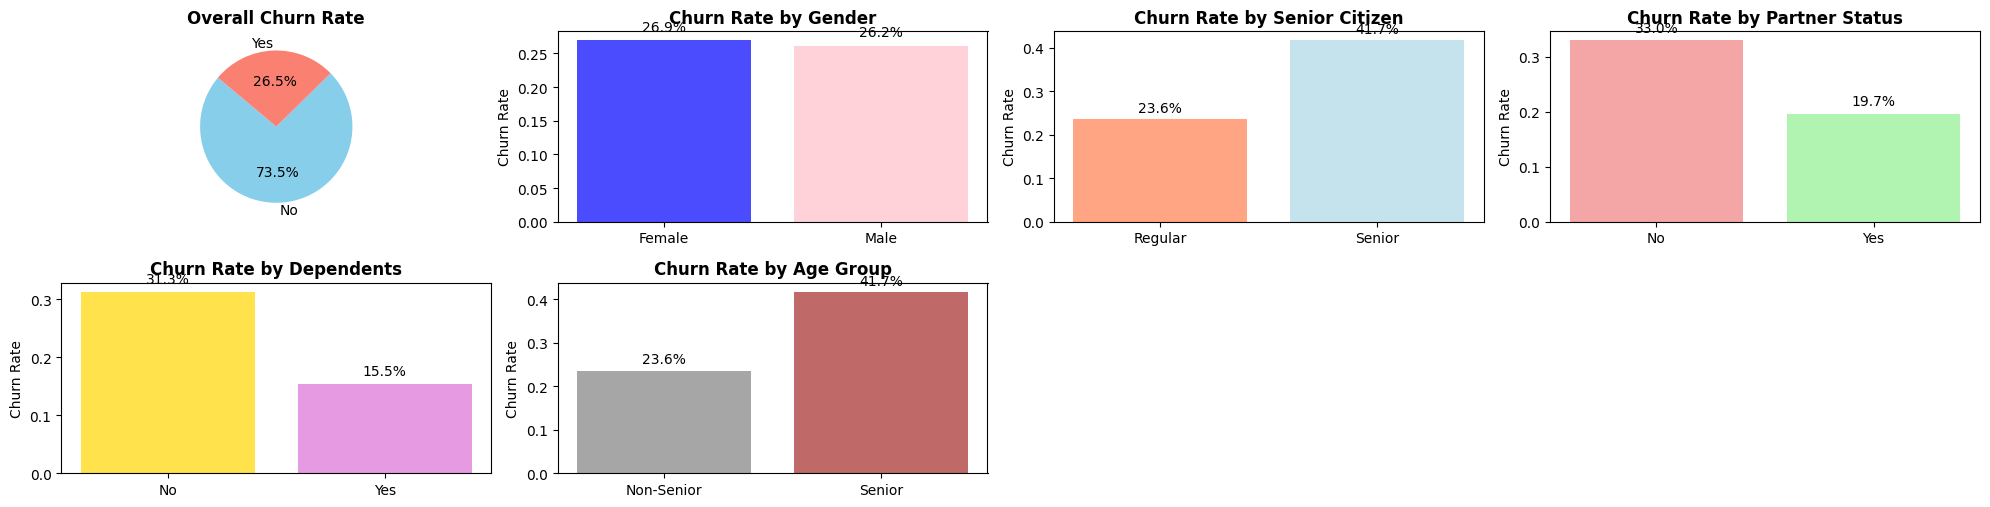

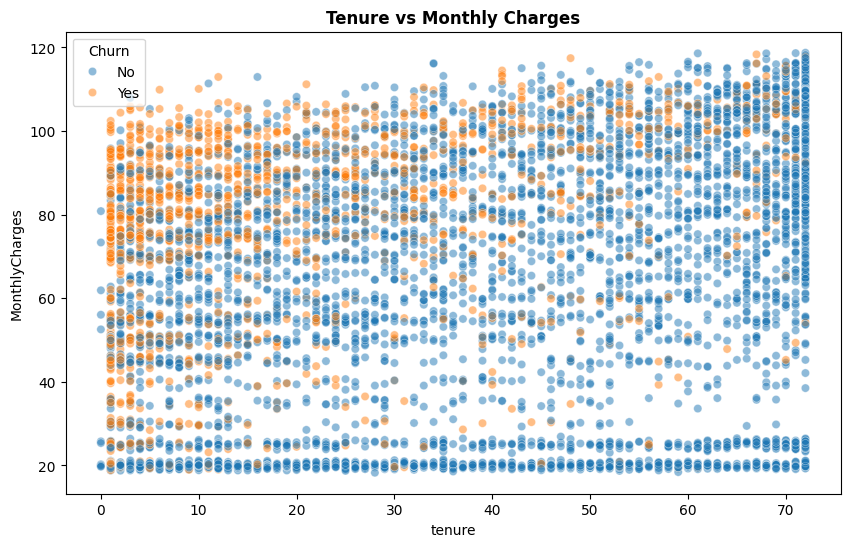

In [24]:
plt.figure(figsize=(20, 15))  # Churn rate on the basis of demographics

# 1. Overall Churn Rate
plt.subplot(6, 4, 1)
churn_counts = df_eda['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
plt.title('Overall Churn Rate', fontweight='bold')

# 2. Gender Distribution
plt.subplot(6, 4, 2)
gender_churn = df_eda.groupby('gender')['Churn_Binary'].mean()
bars = plt.bar(gender_churn.index, gender_churn.values, alpha=0.7, color=['blue', 'pink'])
plt.title('Churn Rate by Gender', fontweight='bold')
plt.ylabel('Churn Rate')

for bar, rate in zip(bars, gender_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')


# 3. Senior Citizen
plt.subplot(6, 4, 3)
senior_churn = df_eda.groupby('SeniorCitizen')['Churn_Binary'].mean()
bars = plt.bar(senior_churn.index.astype(str), senior_churn.values, alpha=0.7, color=['coral', 'lightblue'])
plt.title('Churn Rate by Senior Citizen', fontweight='bold')
plt.ylabel('Churn Rate')
plt.xticks([0, 1], ['Regular', 'Senior'])

for bar, rate in zip(bars, senior_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')


# 4. Partner Status
plt.subplot(6, 4, 4)
partner_churn = df_eda.groupby('Partner')['Churn_Binary'].mean()
bars = plt.bar(partner_churn.index, partner_churn.values, alpha=0.7, color=['lightcoral', 'lightgreen'])
plt.title('Churn Rate by Partner Status', fontweight='bold')
plt.ylabel('Churn Rate')

for bar, rate in zip(bars, partner_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

# 5. Dependents
plt.subplot(6, 4, 5)
dep_churn = df_eda.groupby('Dependents')['Churn_Binary'].mean()
bars = plt.bar(dep_churn.index, dep_churn.values, alpha=0.7, color=['gold', 'orchid'])
plt.title('Churn Rate by Dependents', fontweight='bold')
plt.ylabel('Churn Rate')

for bar, rate in zip(bars, dep_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

# 6. Age Group
plt.subplot(6, 4, 6)
age_group_churn = df_eda.groupby('AgeGroup')['Churn_Binary'].mean()
bars = plt.bar(age_group_churn.index, age_group_churn.values, alpha=0.7, color=['grey', 'brown'])
plt.title('Churn Rate by Age Group', fontweight='bold')
plt.ylabel('Churn Rate')

for bar, rate in zip(bars, age_group_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_eda, x='tenure', y='MonthlyCharges', hue='Churn', alpha=0.5)
plt.title('Tenure vs Monthly Charges', fontweight='bold')
plt.show()

## EDA: Numerical Feature Distribution by Churn

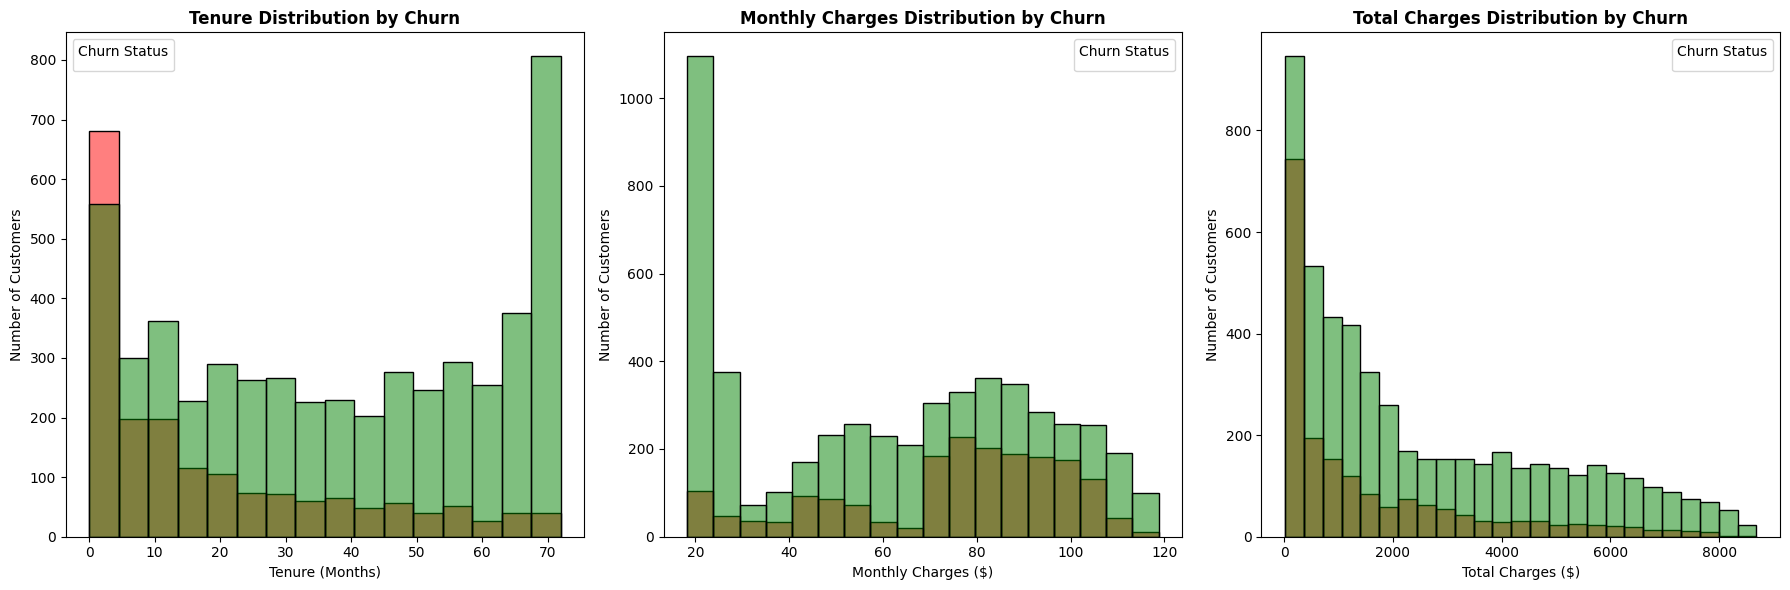

In [25]:
plt.figure(figsize=(18, 6)) # Churn and not churn analysis on the basis of numerical columns

# 1. Tenure Distribution by Churn (Histogram with overlap)
ax1 = plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
sns.histplot(data=df_eda, x='tenure', hue='Churn', palette={'No': 'green', 'Yes': 'red'}, alpha=0.5, ax=ax1)
plt.title('Tenure Distribution by Churn', fontweight='bold')
plt.xlabel('Tenure (Months)')
plt.ylabel('Number of Customers')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=['Retained', 'Churned'], title='Churn Status')

# 2. Monthly Charges Distribution by Churn (Histogram with overlap)
ax2 = plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
sns.histplot(data=df_eda, x='MonthlyCharges', hue='Churn', palette={'No': 'green', 'Yes': 'red'}, alpha=0.5, ax=ax2)
plt.title('Monthly Charges Distribution by Churn', fontweight='bold')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Number of Customers')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=['Retained', 'Churned'], title='Churn Status')

# 3. Total Charges Distribution by Churn (Histogram with overlap)
ax3 = plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
sns.histplot(data=df_eda, x='TotalCharges', hue='Churn', palette={'No': 'green', 'Yes': 'red'}, alpha=0.5, ax=ax3)
plt.title('Total Charges Distribution by Churn', fontweight='bold')
plt.xlabel('Total Charges ($)')
plt.ylabel('Number of Customers')
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles=handles, labels=['Retained', 'Churned'], title='Churn Status')

plt.tight_layout()
plt.show()

## EDA: Churn Rate by Services Provided

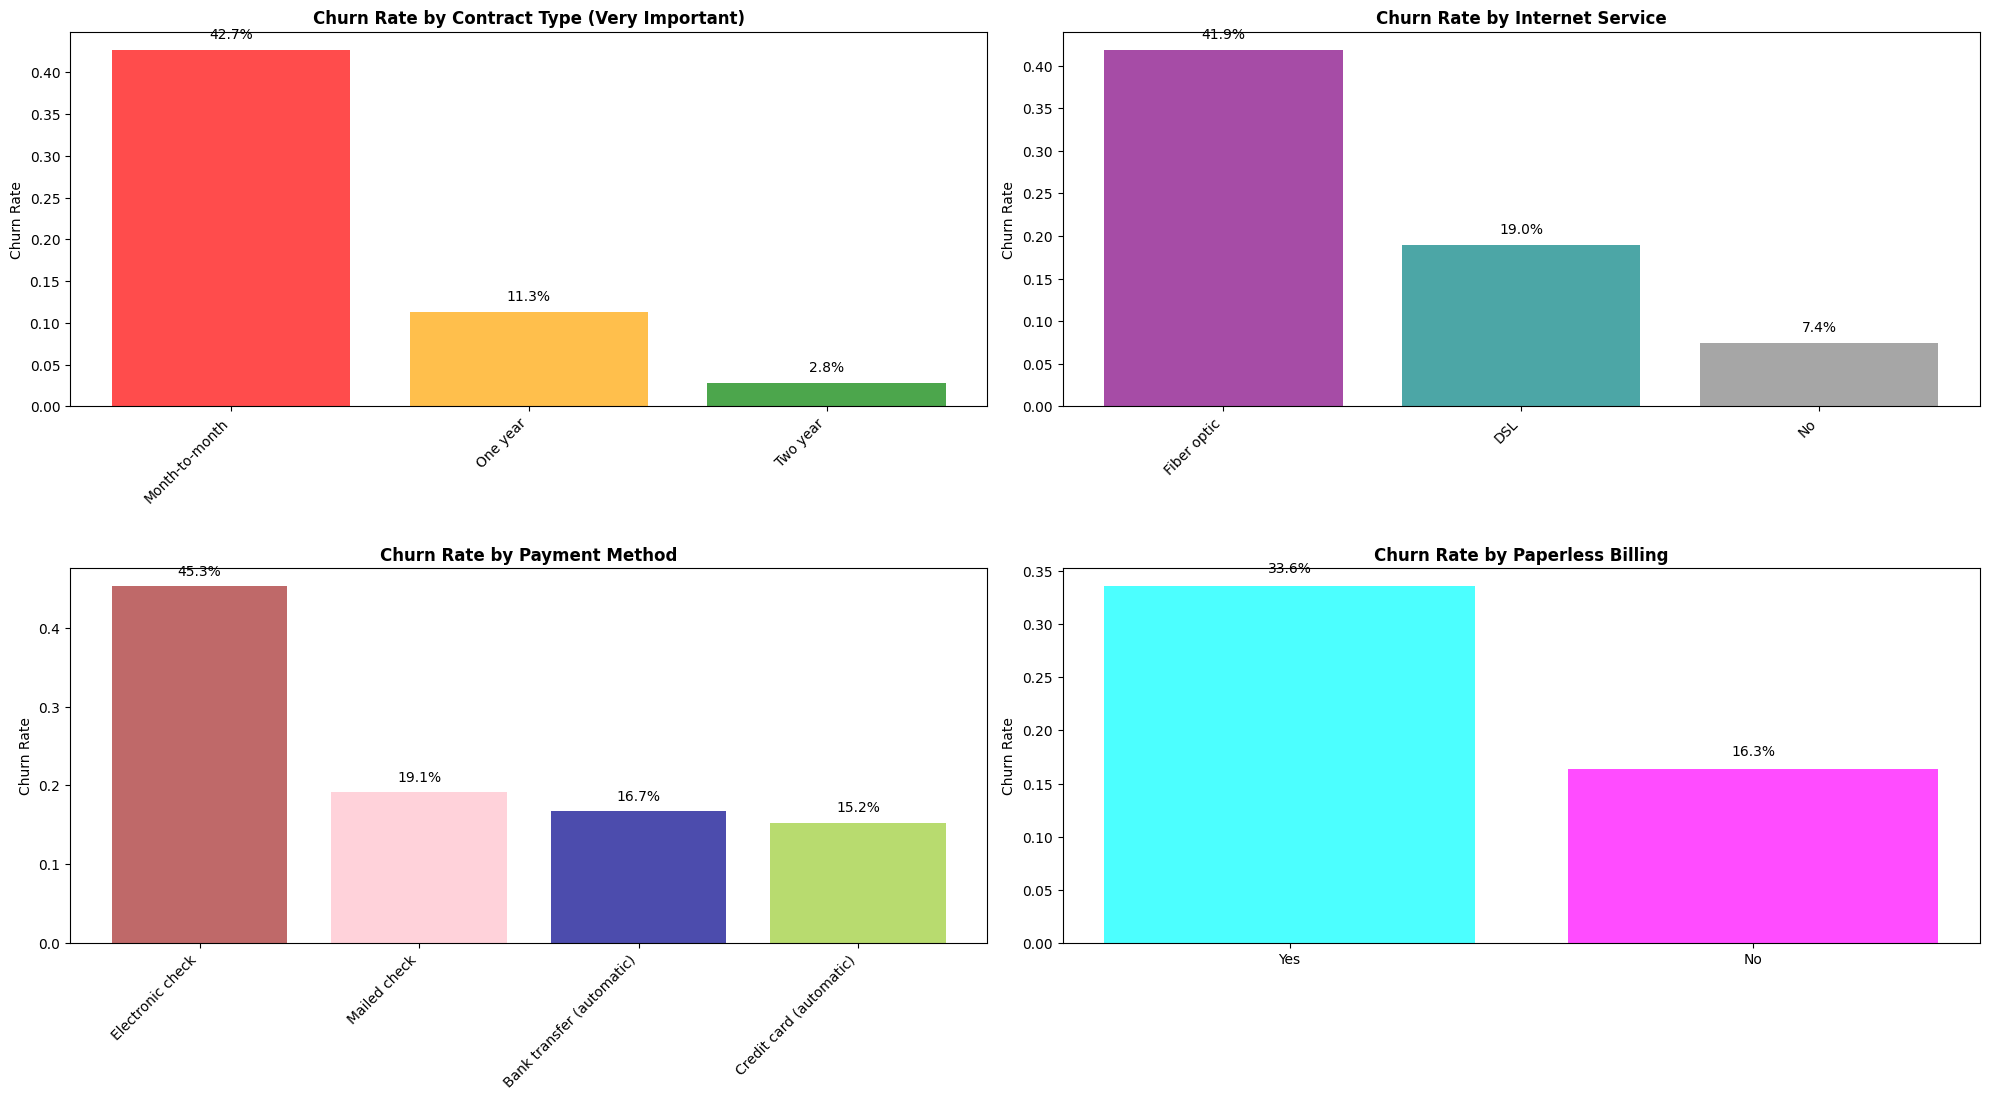

In [26]:
plt.figure(figsize=(20, 15)) # Churn rate on the basis of services

# 1. Contract Type
plt.subplot(3, 2, 1) # 3 rows, 2 columns, 1st plot
contract_churn = df_eda.groupby('Contract')['Churn_Binary'].mean().sort_values(ascending=False)
bars = plt.bar(contract_churn.index, contract_churn.values, alpha=0.7, color=['red', 'orange', 'green'])
plt.title('Churn Rate by Contract Type (Very Important)', fontweight='bold')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45, ha='right')

for bar, rate in zip(bars, contract_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

# 2. Internet Service
plt.subplot(3, 2, 2) # 3 rows, 2 columns, 2nd plot
internet_churn = df_eda.groupby('InternetService')['Churn_Binary'].mean().sort_values(ascending=False)
bars = plt.bar(internet_churn.index, internet_churn.values, alpha=0.7, color=['purple', 'teal', 'grey'])
plt.title('Churn Rate by Internet Service', fontweight='bold')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45, ha='right')

for bar, rate in zip(bars, internet_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

# 3. Payment Method
plt.subplot(3, 2, 3) # 3 rows, 2 columns, 3rd plot
payment_churn = df_eda.groupby('PaymentMethod')['Churn_Binary'].mean().sort_values(ascending=False)
bars = plt.bar(payment_churn.index, payment_churn.values, alpha=0.7, color=['brown', 'pink', 'darkblue', 'yellowgreen'])
plt.title('Churn Rate by Payment Method', fontweight='bold')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45, ha='right')

for bar, rate in zip(bars, payment_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

# 4. Paperless Billing
plt.subplot(3, 2, 4) # 3 rows, 2 columns, 4th plot
paperless_churn = df_eda.groupby('PaperlessBilling')['Churn_Binary'].mean().sort_values(ascending=False)
bars = plt.bar(paperless_churn.index, paperless_churn.values, alpha=0.7, color=['cyan', 'magenta'])
plt.title('Churn Rate by Paperless Billing', fontweight='bold')
plt.ylabel('Churn Rate')

for bar, rate in zip(bars, paperless_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## EDA: Correlation Heatmap of Numerical Features

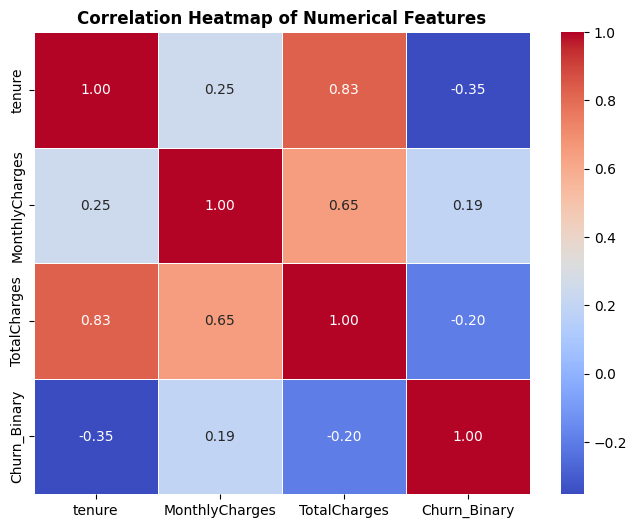

In [27]:
numerical_cols_for_corr = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Binary']
correlation_matrix = df_eda[numerical_cols_for_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features', fontweight='bold')
plt.show()

Text(0.5, 1.0, 'Feature Correlation Matrix')

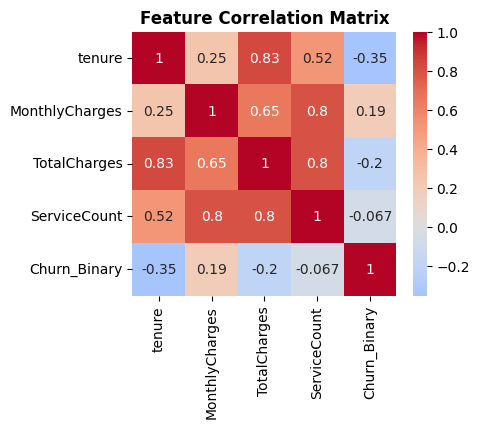

In [28]:
fig = plt.figure(figsize=(20, 24))

service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df_eda['ServiceCount'] = 0
for col in service_cols:
    df_eda['ServiceCount'] += (df_eda[col] == 'Yes').astype(int)

plt.subplot(6, 4, 15)
# Create correlation matrix for key numerical variables
corr_data = df_eda[['tenure', 'MonthlyCharges', 'TotalCharges', 'ServiceCount', 'Churn_Binary']].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix', fontweight='bold')

## Feature Engineering

In [29]:
df_features = df_cleaned.copy()

In [30]:
def get_lifecycle_stage(tenure): # Creating a new column called lifecycle stage on the basis of your score
    if tenure <= 12:
        return 'New' # 0-12 months
    elif tenure <= 24:
        return 'Growing' # 12-24 months
    elif tenure <= 48:
        return 'Mature' # 24-48 months
    else:
        return 'Loyal' # 48+ months

df_features['LifecycleStage'] = df_features['tenure'].apply(get_lifecycle_stage)

In [31]:
df_features["RevenuePerMonth"] = df_features['TotalCharges'] / (df_features['tenure'] + 1)

# calculating the revenue per month on the basis of total charges divided by your total tenure time. And you get to assign a customer value score on the basis of that

In [32]:
service_features = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df_features['ServiceBundleScore'] = 0
for feature in service_features:
    df_features['ServiceBundleScore'] += (df_features[feature] == 'Yes').astype(int)

### calculating service bundle score on the basis of how many services that customer is availing

In [33]:
df_features['HighRiskContract'] = (df_features['Contract'] == 'Month-to-month').astype(int)
df_features['FiberOpticUser'] = (df_features['InternetService'] == 'Fiber optic').astype(int)
df_features['PaperlessHighRisk'] = (df_features['PaperlessBilling'] == 'Yes').astype(int)
df_features['SingleCustomer'] = ((df_features['Partner'] == 'No') &
                                 (df_features['Dependents'] == 'No')).astype(int)

In [34]:
# Price Sensitivity Indicators
df_features['HighMonthlyCharges'] = (df_features['MonthlyCharges'] >
                                    df_features['MonthlyCharges'].quantile(0.75)).astype(int)

# Interaction Features
df_features['TenureChargesRatio'] = df_features['tenure'] / (df_features['MonthlyCharges'] + 1)
df_features['ChargesPerService'] = df_features['MonthlyCharges'] / (df_features['ServiceBundleScore'] + 1)

# Customer Stability Score
df_features['StabilityScore'] = (
    (df_features['Partner'] == 'Yes').astype(int) +
    (df_features['Dependents'] == 'Yes').astype(int) +
    (df_features['Contract'] != 'Month-to-month').astype(int) +
    (df_features['tenure'] > 24).astype(int)
)

In [35]:
df_features['target'] = (df_features['Churn'] == "Yes").astype(int)

In [36]:
df_features['target'] = (df_features['Churn'] == 'Yes').astype(int)

categorical_features = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod', 'LifecycleStage'
]

numerical_features = [
    'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
    'ServiceBundleScore', 'RevenuePerMonth', 'TenureChargesRatio',
    'ChargesPerService', 'StabilityScore'
]

binary_features = [
    'HighRiskContract', 'FiberOpticUser', 'PaperlessHighRisk',
    'SingleCustomer', 'HighMonthlyCharges'
]

In [37]:
from sklearn.preprocessing import LabelEncoder, StandardScaler ### label encoder is used for categorical var and ss is for num
from sklearn.model_selection import train_test_split

In [38]:
df_encoded = df_features.copy()

label_encoders = {}

for feature in categorical_features:
    if feature in ['InternetService', 'Contract', 'PaymentMethod', 'LifecycleStage']:
        # One-hot encode features with multiple meaningful categories
        dummies = pd.get_dummies(df_encoded[feature], prefix=feature, drop_first=False)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        df_encoded = df_encoded.drop(feature, axis=1)
    else:
        # Label encode binary-like categorical features
        le = LabelEncoder()
        df_encoded[feature] = le.fit_transform(df_encoded[feature].astype(str))
        label_encoders[feature] = le

In [39]:
# Define X and y
columns_to_drop = ['customerID', 'Churn']
feature_columns = [col for col in df_encoded.columns if col not in columns_to_drop + ['target']]

X = df_encoded[feature_columns]
y = df_encoded['target']

In [40]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y # Maintain class distribution
)

In [41]:
# Scaling Numerical Features
scaler = StandardScaler()
numerical_cols = [col for col in feature_columns if col in numerical_features or
                 any(num_feat in col for num_feat in numerical_features)]

In [42]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if numerical_cols:
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [43]:
# Correlation-based feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'correlation_with_target': [abs(X_train[col].corr(y_train)) for col in X_train.columns]
}).sort_values('correlation_with_target', ascending=False)

In [44]:
print(feature_importance.head(10).to_string(index=False))

                       feature  correlation_with_target
       Contract_Month-to-month                 0.406401
              HighRiskContract                 0.406401
             ChargesPerService                 0.392478
                StabilityScore                 0.366827
                        tenure                 0.345593
            TenureChargesRatio                 0.335601
            LifecycleStage_New                 0.314332
                FiberOpticUser                 0.312656
   InternetService_Fiber optic                 0.312656
PaymentMethod_Electronic check                 0.309214


In [45]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for imbalanced dataset
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(f"Class weights: {class_weight_dict}")
print(f"Class 0 (No Churn): {class_weights[0]:.2f}")
print(f"Class 1 (Churn): {class_weights[1]:.2f}")

Class weights: {np.int64(0): np.float64(0.6805991785455424), np.int64(1): np.float64(1.8842809364548494)}
Class 0 (No Churn): 0.68
Class 1 (Churn): 1.88


## Deep Learning part

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset

In [47]:
device = 'cpu'

In [48]:
X_train_numpy = X_train_scaled.astype(float).values
X_test_numpy = X_test_scaled.astype(float).values

#Convert to pyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_numpy).to(device)
X_test_tensor = torch.FloatTensor(X_test_numpy).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)

In [49]:
preprocessing_objects = {
    'scaler' : scaler,
    'label_encoders' : label_encoders,
    'feature_columns' : feature_columns,
    'class_weights' : class_weight_dict
}

In [50]:
torch.save(torch.tensor([class_weight_dict[1]], dtype=torch.float), 'class_weight.pt')

## Neural Network Architecture Building

In [51]:
import torch.nn as nn
import torch.nn.functional as f
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import torch.optim as optim

In [61]:
class ChurnPredictor(nn.Module):
      def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.2):
          super(ChurnPredictor, self).__init__()

          #Build dynamic architecture
          layers = []
          prev_size = input_size

          for i, hidden_size in enumerate(hidden_sizes):
              # Linear layer
              layers.append(nn.Linear(prev_size, hidden_size))
              # Batch normalization
              layers.append(nn.BatchNorm1d(hidden_size))
              # Activation
              layers.append(nn.ReLU()) ### a = max{0, a_i} -> relu
              # Dropout
              layers.append(nn.Dropout(dropout_rate))
              prev_size = hidden_size

          # Output layer
          layers.append(nn.Linear(prev_size, 1))
          # layers.append(nn.Sigmoid()) # Sigmoid will be applied in the loss function (BCEWithlogisticloss)

          self.network = nn.Sequential(*layers)

          # Initialize weights
          self._initialize_weights()

      def _initialize_weights(self):
          """ Initialize weights using Xavier/Glorot initialization """
          for module in self.modules():
              if isinstance(module, nn.Linear):
                 nn.init.xavier_uniform_(module.weight)
                 nn.init.constant_(module.bias, 0)

      def forward(self, x):
          return self.network(x)


In [62]:
input_size = X_train_tensor.shape[1]
print(f"   Input size: {input_size} features")

   Input size: 40 features


In [63]:
model = ChurnPredictor(
    input_size=input_size,
    hidden_sizes=[256, 128, 64],  # Progressive reduction
    dropout_rate=0.2
).to(device)

In [64]:
print(sum(p.numel() for p in model.parameters()))

52609


In [65]:
print(model)

ChurnPredictor(
  (network): Sequential(
    (0): Linear(in_features=40, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Explaining the `ChurnPredictor` Neural Network Class

This class defines a simple feedforward neural network designed to predict customer churn. Let's break down its components:

### `class ChurnPredictor(nn.Module):`
*   `nn.Module`: This is the base class for all neural network modules in PyTorch. When you create a custom neural network, you always inherit from `nn.Module`. This gives your class access to PyTorch's functionalities like tracking parameters, moving models to GPU, and more.

### `__init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.2)`
This is the constructor method where you define the layers and components of your neural network.

*   `self`: Refers to the instance of the class itself.
*   `input_size`: This is a crucial parameter. It represents the number of features (columns) in your input data (`X_train_tensor.shape[1]`). For example, if you have 40 features for each customer, `input_size` will be 40.
*   `hidden_sizes=[256, 128, 64]`: This is a list defining the number of neurons in each hidden layer. Here:
    *   The first hidden layer will have 256 neurons.
    *   The second hidden layer will have 128 neurons.
    *   The third hidden layer will have 64 neurons.
    The progressive reduction in `hidden_sizes` (e.g., 256 -> 128 -> 64) is a common practice to gradually condense information as it moves deeper into the network.
*   `dropout_rate=0.2`: This parameter controls the dropout regularization. Dropout is a technique to prevent overfitting. During training, a fraction of neurons specified by `dropout_rate` (here, 20% or 0.2) are randomly "turned off" (their output is set to zero) at each update. This forces the network to learn more robust features and prevents over-reliance on any single neuron.

**Inside `__init__`:**

*   `super(ChurnPredictor, self).__init__()`: Calls the constructor of the parent `nn.Module` class, which is necessary for PyTorch modules.

*   `layers = []`: An empty list to store the sequential layers of the network.

*   `prev_size = input_size`: Keeps track of the input size for the current layer, initially set to the `input_size` of the entire network.

*   **Loop to build Hidden Layers:**
    *   `nn.Linear(prev_size, hidden_size)`: A linear (dense or fully connected) layer. It performs a linear transformation on the input data: `output = input * weight + bias`.
        *   `prev_size`: The number of input features to this layer.
        *   `hidden_size`: The number of output features (neurons) from this layer.
    *   `nn.BatchNorm1d(hidden_size)`: **Batch Normalization** layer. It normalizes the outputs of the previous layer by re-centering and re-scaling them. This helps stabilize and accelerate the training process by reducing internal covariate shift.
    *   `nn.ReLU()`: **Rectified Linear Unit** activation function. It introduces non-linearity into the model, allowing it to learn complex patterns. `ReLU(x) = max(0, x)`. Without activation functions, a neural network would only be able to learn linear relationships.
    *   `nn.Dropout(dropout_rate)`: Applies dropout regularization as explained above.

*   **Output Layer:**
    *   `nn.Linear(prev_size, 1)`: The final linear layer. It takes the output from the last hidden layer (`prev_size`, which is 64 in this case) and produces a single output neuron. Since this is a binary classification problem (churn or no churn), we need one output.
    *   `layers.append(nn.Sigmoid())` (commented out): A Sigmoid activation function is often used in the output layer for binary classification to squash the output between 0 and 1, representing probabilities. However, it's commented out here because the `BCEWithLogitsLoss` loss function (Binary Cross Entropy with Logits) used in PyTorch *expects* the raw, unactivated output (logits) and applies the sigmoid internally for numerical stability.

*   `self.network = nn.Sequential(*layers)`: This wraps all the defined layers into a sequential container. Data will flow through these layers in the order they were added.

*   `self._initialize_weights()`: Calls a helper method to set initial values for the network's weights and biases. This is important for training stability and performance.

### `_initialize_weights(self)`
*   This method iterates through all the modules (layers) in the network.
*   `nn.init.xavier_uniform_(module.weight)`: Applies **Xavier (Glorot) uniform initialization** to the weights of linear layers. This initialization strategy helps to keep the variance of activations consistent across layers, preventing vanishing or exploding gradients during training.
*   `nn.init.constant_(module.bias, 0)`: Initializes the biases of linear layers to zero.

### `forward(self, x)`
This method defines the forward pass of the neural network – how data flows from the input to the output.

*   `x`: Represents the input data (e.g., `X_train_tensor`).
*   `return self.network(x)`: The input `x` is passed through the `self.network` (the `nn.Sequential` container), which applies all the defined layers and operations in sequence, returning the final output (logits before sigmoid) of the network.

In essence, the `ChurnPredictor` creates a flexible, deep neural network architecture that can be easily configured by changing the `hidden_sizes` and `dropout_rate`, making it suitable for learning complex patterns in your customer churn data.

## Comprehensive Example: How a Simple Neural Network Processes Data

Let's imagine a very simple neural network with 2 input features, 1 hidden layer with 2 neurons, and 1 output neuron. We'll walk through the calculations.

**Scenario:** We want to predict if a customer will buy a product based on two features:
1.  **Marketing Score (Input X1):** How responsive they are to marketing (e.g., 0.8)
2.  **Website Visit Duration (Input X2):** How long they spent on the website (e.g., 0.5)

### 1. Inputs
Our input vector `X` is `[X1, X2] = [0.8, 0.5]`.

### 2. Weights and Biases
Each connection between neurons has a `weight`, and each neuron in a layer (except input) has a `bias`. These are the parameters the network learns during training.

Let's assign some arbitrary weights and biases for our example:

*   **Input Layer to Hidden Layer (Layer 1):**
    *   **To Hidden Neuron 1 (H1):**
        *   Weight from X1 to H1 (`W1_1`) = 0.2
        *   Weight from X2 to H1 (`W2_1`) = 0.7
        *   Bias for H1 (`B1_1`) = 0.1
    *   **To Hidden Neuron 2 (H2):**
        *   Weight from X1 to H2 (`W1_2`) = 0.4
        *   Weight from X2 to H2 (`W2_2`) = 0.3
        *   Bias for H2 (`B1_2`) = -0.2

*   **Hidden Layer to Output Layer (Layer 2):**
    *   **To Output Neuron 1 (O1):**
        *   Weight from H1 to O1 (`W_H1_O1`) = 0.6
        *   Weight from H2 to O1 (`W_H2_O1`) = -0.5
        *   Bias for O1 (`B2_1`) = 0.3

### 3. Calculations - Forward Pass

#### A. Hidden Layer (Layer 1) - Calculation of Weighted Sums

*   **For Hidden Neuron 1 (H1):**
    *   `Z_H1 = (X1 * W1_1) + (X2 * W2_1) + B1_1`
    *   `Z_H1 = (0.8 * 0.2) + (0.5 * 0.7) + 0.1`
    *   `Z_H1 = 0.16 + 0.35 + 0.1 = 0.61`

*   **For Hidden Neuron 2 (H2):**
    *   `Z_H2 = (X1 * W1_2) + (X2 * W2_2) + B1_2`
    *   `Z_H2 = (0.8 * 0.4) + (0.5 * 0.3) + (-0.2)`
    *   `Z_H2 = 0.32 + 0.15 - 0.2 = 0.27`

#### B. Hidden Layer (Layer 1) - Activation Function (ReLU)
We apply the ReLU activation function to `Z_H1` and `Z_H2`. `ReLU(x) = max(0, x)`.

*   **Output of H1 (`A_H1`):**
    *   `A_H1 = ReLU(Z_H1) = ReLU(0.61) = 0.61`

*   **Output of H2 (`A_H2`):**
    *   `A_H2 = ReLU(Z_H2) = ReLU(0.27) = 0.27`

Now, the output of our hidden layer is `[0.61, 0.27]`.

#### C. Dropout (If applicable at this layer)
Let's assume a `dropout_rate` of 0.2 (20%). During training, for *this specific forward pass*, one of the hidden neurons might be randomly dropped. If H1 was dropped, its output would become 0, and the other neuron's output would be scaled up (divided by `1 - dropout_rate`) to maintain the expected sum of activations.

For simplicity in this calculation, let's assume no dropout happened for this specific forward pass, so `A_H1 = 0.61` and `A_H2 = 0.27` proceed.

#### D. Output Layer (Layer 2) - Calculation of Weighted Sum

*   **For Output Neuron 1 (O1):**
    *   `Z_O1 = (A_H1 * W_H1_O1) + (A_H2 * W_H2_O1) + B2_1`
    *   `Z_O1 = (0.61 * 0.6) + (0.27 * -0.5) + 0.3`
    *   `Z_O1 = 0.366 - 0.135 + 0.3 = 0.531`

#### E. Output Layer (Layer 2) - Activation Function (Sigmoid for probability)
Since this is a binary classification, we apply a Sigmoid function to get a probability between 0 and 1. `Sigmoid(x) = 1 / (1 + e^-x)`.

*   **Output of O1 (`Predicted Probability`):**
    *   `Predicted Probability = Sigmoid(Z_O1) = Sigmoid(0.531)`
    *   `Sigmoid(0.531) ≈ 1 / (1 + e^-0.531) ≈ 1 / (1 + 0.587) ≈ 1 / 1.587 ≈ 0.63`

### 4. Result
Our simple neural network predicts that this customer has a **63% probability** of buying the product.

### Summary of Concepts Illustrated:

*   **Inputs:** Raw data features.
*   **Weights:** Coefficients that determine the strength of connections between neurons.
*   **Biases:** Values added to the weighted sum, allowing neurons to be activated even with zero input.
*   **Linear Layer (`nn.Linear`):** Performs the `(input * weight) + bias` calculation.
*   **Activation Function (`ReLU`):** Introduces non-linearity, enabling the network to learn complex patterns. Without it, stacking layers would just result in another linear function.
*   **Batch Normalization (`nn.BatchNorm1d`):** Not shown explicitly in the manual calculation above, but it would standardize the outputs of the linear layer *before* the activation function, helping to stabilize learning.
*   **Dropout (`nn.Dropout`):** A regularization technique that randomly deactivates neurons during training, preventing overfitting. If a neuron is dropped, its output for that specific pass would be 0, and other active neurons might have their outputs scaled up.
*   **Sequential (`nn.Sequential`):** Organizes layers in a clear, feedforward path.
*   **Output Layer:** Produces the final prediction, often followed by an activation function (like Sigmoid for probability) depending on the task and loss function.

##code continuation

In [68]:
# Weighted loss for imbalanced dataset
# BCEWithLogitsLoss combines Sigmoid and BCELoss for numerical stability

pos_weight_tensor = torch.tensor([class_weight_dict[1]], dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)


#Adam optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) # Adjusted learning rate and weight decay

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [69]:
from sklearn.model_selection import train_test_split

X_val_split, X_train_split, y_val_split, y_train_split = train_test_split(
    X_train_tensor.cpu().numpy(), y_train_tensor.cpu().numpy(),
    test_size=0.8,
    random_state=42,
    stratify=y_train_tensor.cpu().numpy()
)

# Convert back to tensors

X_train_split_tensor = torch.FloatTensor(X_train_split).to(device)
X_val_split_tensor = torch.FloatTensor(X_val_split).to(device)
y_train_split_tensor = torch.FloatTensor(y_train_split).to(device)
y_val_split_tensor = torch.FloatTensor(y_val_split).to(device)

print(f"    Training split: {X_train_split_tensor.shape}")
print(f"    Validation split: {X_val_split_tensor.shape}")

    Training split: torch.Size([4508, 40])
    Validation split: torch.Size([1126, 40])


In [70]:
def train_epoch(model, X_train, y_train, optimizer, criterion):
    """ Train model for one epoch """
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    return loss.item()

In [74]:
def validate_epoch(model, X_val, y_val, criterion):
    """ Validate model for one epoch """
    model.eval()
    with torch.no_grad():
         outputs = model(X_val).squeeze()
         loss = criterion(outputs, y_val)

         predictions = torch.sigmoid(outputs)
         predicted_classes = (predictions > 0.5).float()

         accuracy = (predicted_classes == y_val).float().mean()

    return loss.item(), accuracy.item(), predictions.cpu().numpy()

In [76]:
"""
num_epochs = 500
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 25

# Training history
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, X_train_split_tensor, y_train_split_tensor,
                             optimizer, criterion)

    val_loss, val_accuracy, val_predictions = validate_epoch(
        model, X_val_split_tensor, y_val_split_tensor, criterion
    )

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    current_lr = optimizer.param_groups[0]['lr']
    if epoch % 10 == 0 or epoch < 10:
       print(f"{epoch+1:<6} {train_loss:<12.4f} {val_loss:<12.4f} {val_accuracy:<10.3f} {current_lr:<10.6f}")

    if val_loss < best_val_loss:
       best_val_loss = val_loss
       patience_counter = 0
       torch.save(model.state_dict(), 'best_churn_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break
    """

'\nnum_epochs = 500 \nbest_val_loss = float(\'inf\') \npatience_counter = 0\npatience_limit = 25\n\n# Training history\ntrain_losses = []\nval_losses = []\nval_accuracies = []\n\nfor epoch in range(num_epochs):\n    train_loss = train_epoch(model, X_train_split_tensor, y_train_split_tensor,\n                             optimizer, criterion)\n    \n    val_loss, val_accuracy, val_predictions = validate_epoch(\n        model, X_val_split_tensor, y_val_split_tensor, criterion\n    ) \n\n    scheduler.step(val_loss) \n\n    train_losses.append(train_loss)\n    val_losses.append(val_loss) \n    val_accuracies.append(val_accuracy) \n\n    current_lr = optimizer.param_groups[0][\'lr\']\n    if epoch % 10 == 0 or epoch < 10:\n       print(f"{epoch+1:<6} {train_loss:<12.4f} {val_loss:<12.4f} {val_accuracy:<10.3f} {current_lr:<10.6f}") \n\n    if val_loss < best_val_loss: \n       best_val_loss = val_loss \n       patience_counter = 0\n       torch.save(model.state_dict(), \'best_churn_model.pt

In [75]:
num_epochs = 500
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 25

# Training history
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, X_train_split_tensor, y_train_split_tensor,
                             optimizer, criterion)

    val_loss, val_accuracy, val_predictions = validate_epoch(
        model, X_val_split_tensor, y_val_split_tensor, criterion
    )

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    current_lr = optimizer.param_groups[0]['lr']
    if epoch % 10 == 0 or epoch < 10:
       print(f"{epoch+1:<6} {train_loss:<12.4f} {val_loss:<12.4f} {val_accuracy:<10.3f} {current_lr:<10.6f}")

    if val_loss < best_val_loss:
       best_val_loss = val_loss
       patience_counter = 0
       torch.save(model.state_dict(), 'best_churn_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

1      0.9705       0.8322       0.520      0.000100  
2      0.9470       0.8315       0.520      0.000100  
3      0.9355       0.8290       0.533      0.000100  
4      0.9298       0.8252       0.550      0.000100  
5      0.8979       0.8207       0.556      0.000100  
6      0.8875       0.8161       0.569      0.000100  
7      0.8799       0.8109       0.593      0.000100  
8      0.8622       0.8052       0.597      0.000100  
9      0.8595       0.7993       0.608      0.000100  
10     0.8491       0.7933       0.620      0.000100  
11     0.8395       0.7871       0.628      0.000100  
21     0.7748       0.7326       0.671      0.000100  
31     0.7524       0.7099       0.690      0.000100  
41     0.7310       0.7044       0.700      0.000100  
51     0.7204       0.7000       0.709      0.000100  
61     0.7080       0.6938       0.718      0.000100  
71     0.6946       0.6878       0.725      0.000100  
81     0.6913       0.6816       0.725      0.000100  
91     0.6

In [77]:
model.load_state_dict(torch.load('best_churn_model.pth'))

<All keys matched successfully>

## Explaining the Training Process: Epochs, Optimizer, Loss, and Evaluation

This section explains the core components that drive the learning process of our neural network.

### **1. Loss Function and Optimizer Setup**

**Code (`lmiRDdw8neL1`):**
```python
# Weighted loss for imbalanced dataset
# BCEWithLogitsLoss combines Sigmoid and BCELoss for numerical stability
pos_weight_tensor = torch.tensor([class_weight_dict[1]], dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

#Adam optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) # Adjusted learning rate and weight decay

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
```
**Explanation:**

*   **`pos_weight_tensor` and `criterion = nn.BCEWithLogitsLoss(...)`:**
    *   **Class Imbalance:** Our dataset for churn prediction is imbalanced (more 'No Churn' than 'Yes Churn' customers). If not handled, the model might become biased towards the majority class.
    *   **`pos_weight_tensor`:** This is a crucial parameter passed to the loss function. It's the `class_weight_dict[1]` (the weight for the positive class, 'Churn'). By assigning a higher weight to the minority class (churners), we tell the model to pay more attention to correctly classifying these instances, even if they are few.
    *   **`nn.BCEWithLogitsLoss`:** This is PyTorch's binary cross-entropy loss function. It's commonly used for binary classification tasks. The `WithLogits` part means it expects raw model outputs (logits) and applies a sigmoid activation internally for numerical stability. It calculates the difference between the model's predicted probability and the true label.
    *   **How it works:** When a churner is misclassified, this loss function penalizes the model *more* severely due to `pos_weight_tensor`, encouraging it to improve its performance on churn prediction.

*   **`optimizer = optim.Adam(...)`:**
    *   **Optimizer's Role:** The optimizer is the

## Comprehensive Explanation of the Neural Network Implementation

This section will walk you through the entire process of building, training, and evaluating a neural network for customer churn prediction. We'll explain each code block in detail, including key concepts for beginners.

### **1. Building Neural Network Architecture**

This phase focuses on defining the structure of our neural network, much like drawing a blueprint for a building.

#### **1.1. Importing Deep Learning Libraries**

**Code (`UpoIegy4CYEW`):**
```python
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
```
**Explanation:**
*   `torch`: This is the main PyTorch library, a powerful open-source machine learning framework. Think of it as our primary toolkit.
*   `torch.nn as nn`: This module provides all the building blocks for neural networks (e.g., layers like `Linear`, activation functions, etc.). `nn` is a common alias for it.
*   `torch.optim as optim`: This module contains various optimization algorithms (like SGD, Adam) that help the network learn by adjusting its weights.
*   `torch.nn.functional as f`: This module contains functional interfaces for neural network operations (e.g., `relu`, `sigmoid`). It's often used when you don't need to create a new `nn.Module` object for a specific function.
*   `from torch.utils.data import DataLoader, TensorDataset`: These are utilities for handling data. `TensorDataset` helps wrap our data into a format PyTorch understands, and `DataLoader` helps us efficiently feed data to the network in batches during training.

#### **1.2. Setting the Device for Computation**

**Code (`MytcNeK7C8Bc`):**
```python
device = 'cpu'
```
**Explanation:**
*   `device = 'cpu'`: This line specifies where our computations will happen. `'cpu'` means the Central Processing Unit of your computer. If you had a powerful GPU (Graphics Processing Unit, like an NVIDIA card), you could set this to `'cuda'` for much faster training. For typical Colab setups without explicit GPU allocation or for smaller models, `'cpu'` is standard.

#### **1.3. Preparing Data for PyTorch**

**Code (`bcpDl5rtBdL8`):**
```python
X_train_numpy = X_train_scaled.astype(float).values
X_test_numpy = X_test_scaled.astype(float).values

#Convert to pyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_numpy).to(device)
X_test_tensor = torch.FloatTensor(X_test_numpy).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)
```
**Explanation:**
*   **Why convert?** PyTorch models work directly with `torch.Tensor` objects, not Pandas DataFrames or NumPy arrays. This step converts our preprocessed data into the required format.
*   `X_train_scaled.astype(float).values`: We first ensure our scaled feature data (`X_train_scaled`) is of a floating-point type (important for neural network calculations) and then convert it into a NumPy array using `.values`.
*   `torch.FloatTensor(...)`: This creates a PyTorch tensor with single-precision floating-point numbers from the NumPy array.
*   `.to(device)`: This moves the created tensors to the specified device (`'cpu'` in our case). If we were using a GPU, this would transfer the data to GPU memory.

#### **1.4. Storing Preprocessing Objects**

**Code (`MOULYZcrDZzv`):**
```python
preprocessing_objects = {
    'scaler' : scaler,
    'label_encoders' : label_encoders,
    'feature_columns' : feature_columns,
    'class_weights' : class_weight_dict
}
```
**Explanation:**
*   This dictionary stores essential objects used during data preprocessing. This is crucial for **deployment**. When you want to use your trained model on *new, unseen data*, you'll need to apply the exact same scaling and encoding transformations. Saving these objects ensures consistency.
    *   `'scaler'`: The `StandardScaler` object used to scale numerical features.
    *   `'label_encoders'`: A dictionary of `LabelEncoder` objects used for categorical features.
    *   `'feature_columns'`: A list of the final feature columns, ensuring new data has the same structure.
    *   `'class_weights'`: The calculated class weights, needed if the model is retrained or if the loss function requires them.

#### **1.5. Saving Class Weights**

**Code (`HAkJJGC7D9LX`):**
```python
torch.save(torch.tensor([class_weight_dict[1]], dtype=torch.float), 'class_weight.pt')
```
**Explanation:**
*   `class_weight_dict[1]`: This refers to the weight calculated for the positive class (churn = 1), which is typically higher in imbalanced datasets to give more importance to the minority class.
*   `torch.tensor(...)`: Converts the weight into a PyTorch tensor.
*   `torch.save(..., 'class_weight.pt')`: This saves the class weight tensor to a file named `class_weight.pt`. This allows us to easily load this specific weight later, for example, when initializing the loss function or if we need to retrain.

#### **1.6. Importing Additional Deep Learning Modules (Redundant but harmless)**

**Code (`AQWhQ90GESbC` - *Note: This cell was executed earlier, these imports were repeated later for clarity in the notebook flow, but functionally they are already loaded*):**
```python
import torch.nn as nn
import torch.nn.functional as f
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import torch.optim as optim
```
**Explanation:**
*   This cell just re-imports some modules that were already imported in cell `UpoIegy4CYEW`. It also adds `ReduceLROnPlateau` for learning rate scheduling and `sklearn.metrics` for evaluation metrics (though these aren't used in the model definition itself).

#### **1.7. Defining the Neural Network Architecture: `ChurnPredictor` Class**

**Code (`umttCtSjFoyA`):**
```python
class ChurnPredictor(nn.Module):
      def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.2):
          super(ChurnPredictor, self).__init__()

          #Build dynamic architecture
          layers = []
          prev_size = input_size

          for i, hidden_size in enumerate(hidden_sizes):
              # Linear layer
              layers.append(nn.Linear(prev_size, hidden_size))
              # Batch normalization
              layers.append(nn.BatchNorm1d(hidden_size))
              # Activation
              layers.append(nn.ReLU()) ### a = max{0, a_i} -> relu
              # Dropout
              layers.append(nn.Dropout(dropout_rate))
              prev_size = hidden_size

          # Output layer
          layers.append(nn.Linear(prev_size, 1))
          # layers.append(nn.Sigmoid()) # Sigmoid will be applied in the loss function (BCEWithlogisticloss)

          self.network = nn.Sequential(*layers)

          # Initialize weights
          self._initialize_weights()

      def _initialize_weights(self):
          """ Initialize weights using Xavier/Glorot initialization """
          for module in self.modules():
              if isinstance(module, nn.Linear):
                 nn.init.xavier_uniform_(module.weight)
                 nn.init.constant_(module.bias, 0)

      def forward(self, x):
          return self.network(x)
```
**Explanation:**
This is the core of our neural network! It defines a multi-layered perceptron (a type of feedforward neural network).

*   `class ChurnPredictor(nn.Module):`: All neural networks in PyTorch inherit from `nn.Module`. This gives them powerful features like tracking learnable parameters (weights and biases), easily moving the model to different devices (CPU/GPU), and managing the forward/backward passes.

*   `__init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.2)`:
    *   This is the constructor. It's where you define the *architecture* of your network.
    *   `input_size`: The number of features your model will receive (e.g., 40 features for each customer).
    *   `hidden_sizes`: A list defining the number of neurons in each *hidden layer*. Here, `[256, 128, 64]` means the first hidden layer has 256 neurons, the second 128, and the third 64. The decreasing size is a common practice to progressively distill information.
    *   `dropout_rate`: A value (e.g., 0.2 means 20%) used for Dropout regularization. This helps prevent overfitting by randomly

In [78]:
# Make predictions on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_probabilities = torch.sigmoid(test_outputs)
    test_predictions = (test_probabilities > 0.5).float()

# Convert tensors to numpy arrays for easier DataFrame creation
y_test_np = y_test.values
test_probabilities_np = test_probabilities.cpu().numpy()
test_predictions_np = test_predictions.cpu().numpy()

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'customerID': df_cleaned.loc[X_test.index, 'customerID'],
    'Actual_Churn': y_test_np,
    'Predicted_Churn_Probability': test_probabilities_np,
    'Predicted_Churn_Class': test_predictions_np
})

# Display the first few rows of the predictions DataFrame
print("Final Predictions on Test Set:")
display(predictions_df.head())

# Export predictions to a CSV file
output_filename = 'churn_predictions.csv'
predictions_df.to_csv(output_filename, index=False)
print(f"\nPredictions exported to {output_filename}")

Final Predictions on Test Set:


,customerID,Actual_Churn,Predicted_Churn_Probability,Predicted_Churn_Class
437,4376-KFVRS,0,0.087967,0.0
2280,2754-SDJRD,0,0.890617,1.0
2235,9917-KWRBE,0,0.202715,0.0
4460,0365-GXEZS,0,0.572111,1.0
3761,9385-NXKDA,0,0.062019,0.0



Predictions exported to churn_predictions.csv
